In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils.prepare_dataset import prepare_dataset_fixedsize

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [3]:
max_seq_len = 64
batch_size = 64


geom_train, geom_val, label_train, label_val, gs = prepare_dataset_fixedsize(dataset_size=2000)

train_tokens = torch.tensor(geom_train, dtype=torch.float32)
val_tokens = torch.tensor(geom_val, dtype=torch.float32)
train_labels= torch.tensor(label_train, dtype=torch.long)
val_labels = torch.tensor(label_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [4]:
train_tokens[2]
from utils.vector2shape import reverse_vector_polygon

polygon = reverse_vector_polygon(train_tokens[7])

In [44]:
class Autoencoder(nn.Module):
    def __init__(self, seq_len, fea_dim, laten_dim):
        super().__init__()
        self.latent_dim = laten_dim
        self.input_size = seq_len * fea_dim
        self.encoder = nn.Sequential(nn.Flatten(),
                                     nn.Linear(self.input_size, laten_dim),
                                     nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(laten_dim, self.input_size))
        self.mse_loss_func = nn.MSELoss()
        self.meta_loss_func = nn.CrossEntropyLoss()
        
    def forward(self, x):
        shape = x.shape
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.contiguous().view(shape)

        coord_output = decoded[:, :, :2]
        meta_output = decoded[:, :, 2:]
        target_meta = torch.argmax(x[:, :, 2:], dim=-1)
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :2])
        # 3 is meta one-hot vocab size
        meta_loss = self.meta_loss_func(meta_output.contiguous().view(-1, 3), target_meta.contiguous().view(-1))

        meta_indices = torch.argmax(meta_output, dim=-1)
        output = torch.cat([coord_output, nn.functional.one_hot(meta_indices, 3)], dim=-1)

        return output, coord_loss*0.25 + meta_loss*0.75

        # return decoded, coord_loss

In [6]:
# import torch
# import torch.nn.functional as F

# x = torch.rand((2, 4, 5))
# decoded = torch.rand((2, 4, 5))
# print(decoded)
# coord_output = decoded[:, :, :2]
# meta_output = decoded[:, :, 2:]
# target_meta = torch.argmax(x[:, :, 2:], dim=-1)

# coord_loss = nn.MSELoss()(coord_output, x[:, :, :2])
# meta_loss = nn.CrossEntropyLoss()(meta_output.contiguous().view(-1, 3), target_meta.contiguous().view(-1))

# meta_indices = torch.argmax(meta_output, dim=-1)
# decoded[:, :, 2:] = F.one_hot(meta_indices, 3)

In [60]:
autoencoder = Autoencoder(64, 5, 128)
loss_func = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epoch = 100

for epoch in range(num_epoch):
    autoencoder.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs, loss = autoencoder(inputs)
        # loss = loss_func(outputs[:, :, :2], inputs[:, :, :2])
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    autoencoder.eval()
    with torch.no_grad():
        val_outputs, loss = autoencoder(val_tokens)
        # loss = loss_func(outputs, val_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch 1, Train Loss: 0.45254793465137483, Val Loss: 0.1517692506313324
Epoch 2, Train Loss: 0.10025634497404098, Val Loss: 0.06770660728216171
Epoch 3, Train Loss: 0.05352450206875801, Val Loss: 0.04434003680944443
Epoch 4, Train Loss: 0.03772355683147907, Val Loss: 0.03524504601955414
Epoch 5, Train Loss: 0.03033259876072407, Val Loss: 0.029606137424707413
Epoch 6, Train Loss: 0.02576472207903862, Val Loss: 0.026060273870825768
Epoch 7, Train Loss: 0.022179763913154602, Val Loss: 0.02361154556274414
Epoch 8, Train Loss: 0.01946460872888565, Val Loss: 0.020941007882356644
Epoch 9, Train Loss: 0.017342574149370193, Val Loss: 0.01916954666376114
Epoch 10, Train Loss: 0.015640199705958365, Val Loss: 0.017429620027542114
Epoch 11, Train Loss: 0.014325690641999244, Val Loss: 0.016395147889852524
Epoch 12, Train Loss: 0.01314180139452219, Val Loss: 0.015601511113345623
Epoch 13, Train Loss: 0.012176823988556861, Val Loss: 0.014502473175525665
Epoch 14, Train Loss: 0.011301473714411259, Val L

In [21]:
from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt


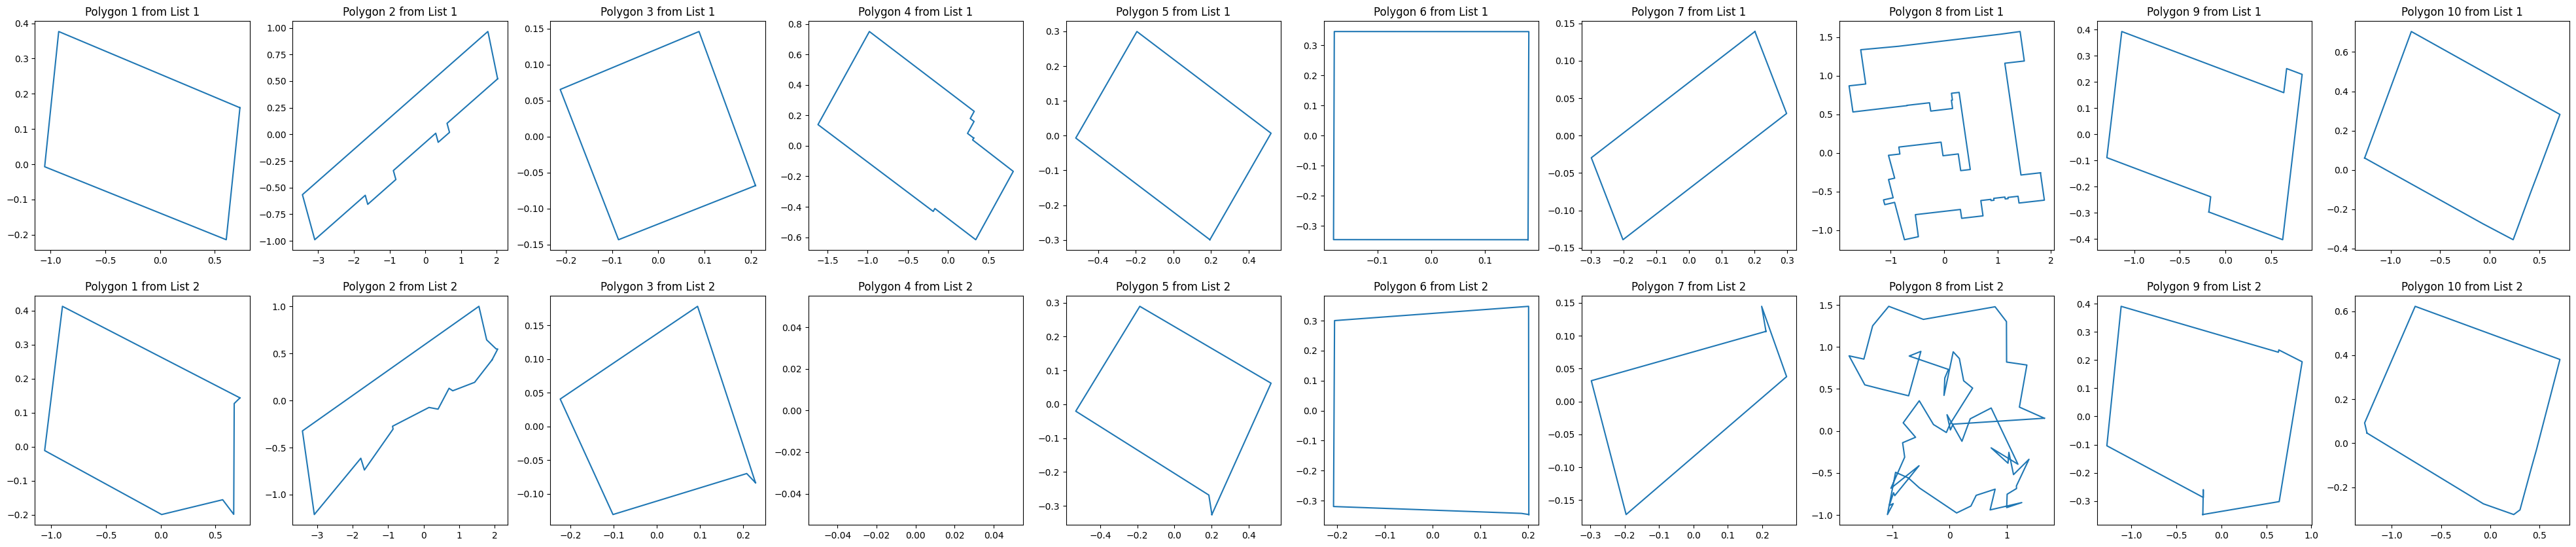

In [61]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

num_samples = 10
ori_polygons = [reverse_vector_polygon(token) for token in val_tokens[:num_samples]]
new_polygons = [reverse_vector_polygon(token) for token in val_outputs[:num_samples]]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)

# Show the plot
plt.show()
